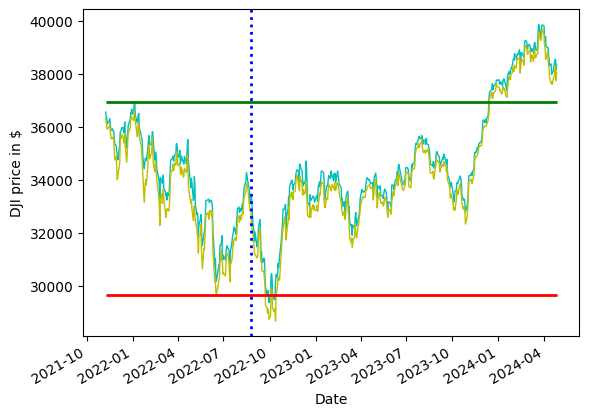

In [1]:
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)

dji_data=dji_data_result.tail(620)
dji_data.index = pd.to_datetime(dji_data.index)
lows=dji_data['Low']
highs=dji_data['High']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='DJI price in $')
highs.plot(ax=ax1, color='c', lw=1.)
lows.plot(ax=ax1, color='y', lw=1.)

plt.hlines(highs.head(200).max(), lows.index.values[0], lows.index.values[-1], linewidth=2, color='g')
plt.hlines(lows.head(200).min(), lows.index.values[0], lows.index.values[-1], linewidth=2, color='r')
plt.axvline(linewidth=2, color='b', x=lows.index.values[200], linestyle=':')
plt.show()

In [2]:
import pandas as pd
import numpy as np

def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0

    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['price'])
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data["res"][x] = resistance_level
        data["sup"][x] = support_level
        data["sup_tolerance"][x] = support_level + 0.2 * range_level
        data["res_tolerance"][x] = resistance_level - 0.2 * range_level
        if data['price'][x]>=data['res_tolerance'][x] and\
            data['price'][x] <= data['res'][x]:
            in_resistance+=1
            data["res_count"][x] = in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and \
            data['price'][x] >= data['sup'][x]:
            in_support += 1
            data["sup_count"][x] = in_support
        else:
            in_support=0
            in_resistance=0

        if in_resistance>2:
            data["signal"][x] = 1
        elif in_support>2:
            data["signal"][x] = 0
        else:
            data['signal'][x] = data['signal'][x - 1]

    data['positions']=data['signal'].diff()

C:\Users\NeroHP\AppData\Local\Temp\ipykernel_9816\399443881.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["res"][x] = resistance_level
C:\Users\NeroHP\AppData\Local\Temp\ipykernel_9816\399443881.py:21: FutureWarning: Series.__set

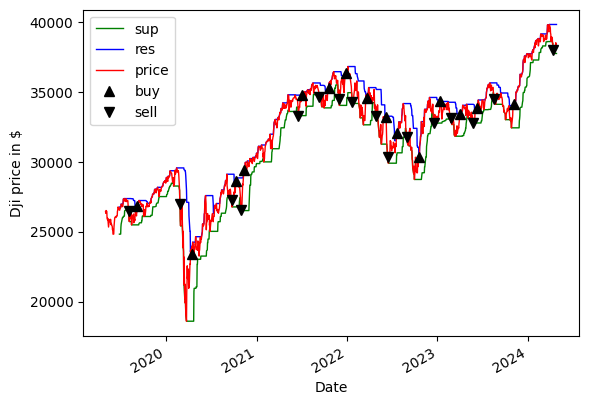

In [3]:
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)

dji_data_result.index = pd.to_datetime(dji_data_result.index)

dji_data_signal = pd.DataFrame(index=dji_data_result.index)
dji_data_signal['price'] = dji_data_result['Close']

trading_support_resistance(dji_data_signal)

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Dji price in $')

dji_data_signal['sup'].plot(ax=ax1, color='g', lw=1.)
dji_data_signal['res'].plot(ax=ax1, color='b', lw=1.)
dji_data_signal['price'].plot(ax=ax1, color='r', lw=1.)

ax1.plot(dji_data_signal.loc[dji_data_signal.positions == 1.0].index, dji_data_signal.price[dji_data_signal.positions == 1.0], '^', markersize=7, color='k',label='buy')
ax1.plot(dji_data_signal.loc[dji_data_signal.positions == -1.0].index, dji_data_signal.price[dji_data_signal.positions == -1.0], 'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

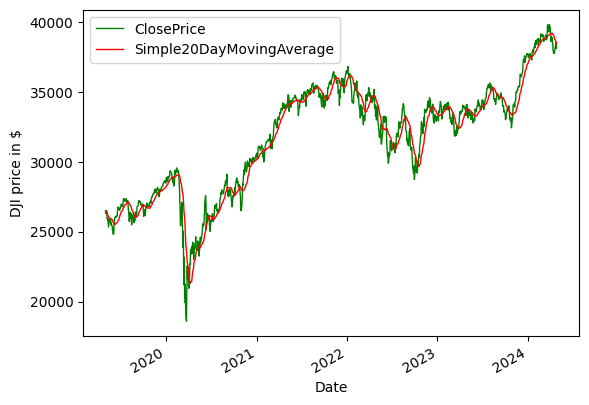

In [2]:
import statistics as stats
import pandas as pd

time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)

dji_data_result.index = pd.to_datetime(dji_data_result.index)

close = dji_data_result['Close']

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
        del (history[0])
    
    sma_values.append(stats.mean(history))

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
sma = dji_data_result['Simple20DayMovingAverage']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
sma.plot(ax=ax1, color='r', lw=1., legend=True)
plt.show()

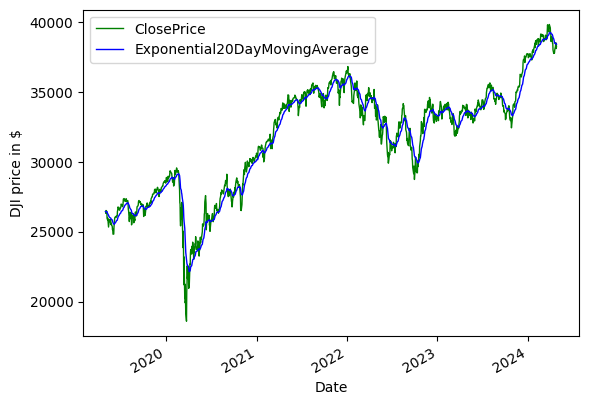

In [4]:
import statistics as stats
import pandas as pd

num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0
ema_values = [] # to hold computed EMA values

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)

dji_data_result.index = pd.to_datetime(dji_data_result.index)

close = dji_data_result['Close']

for close_price in close:
    if (ema_p == 0): # first observation, EMA = current-price
        ema_p = close_price
    else:
        ema_p = (close_price - ema_p) * K + ema_p

    ema_values.append(ema_p)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
ema = dji_data_result['Exponential20DayMovingAverage']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema.plot(ax=ax1, color='b', lw=1., legend=True)
plt.savefig('ema.png')
plt.show()

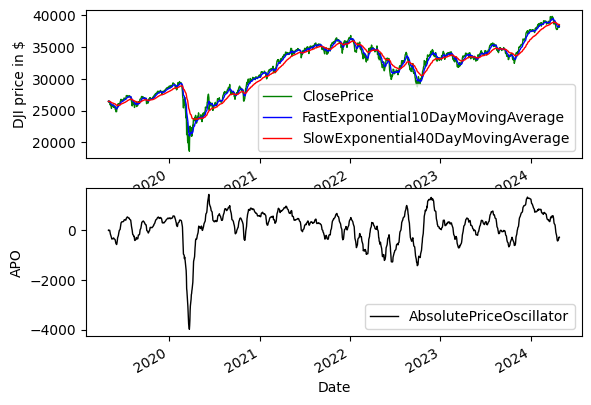

In [6]:
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)
dji_data_result.index = pd.to_datetime(dji_data_result.index)
close = dji_data_result['Close']

num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0

num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values

for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
ema_f = dji_data_result['FastExponential10DayMovingAverage']
ema_s = dji_data_result['SlowExponential40DayMovingAverage']
apo = dji_data_result['AbsolutePriceOscillator']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema_f.plot(ax=ax1, color='b', lw=1., legend=True)
ema_s.plot(ax=ax1, color='r', lw=1., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=1., legend=True)
plt.show()

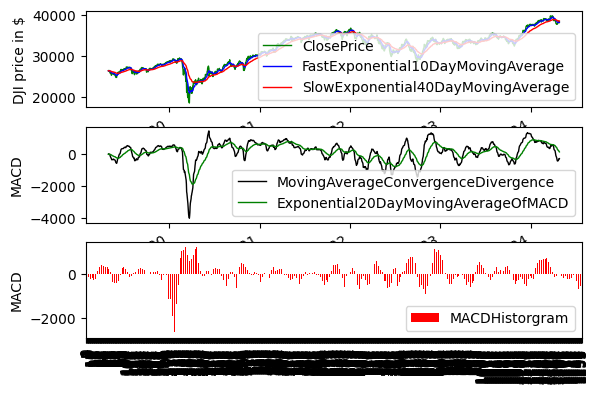

In [5]:
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)
dji_data_result.index = pd.to_datetime(dji_data_result.index)
close = dji_data_result['Close']

num_periods_fast = 10 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0

num_periods_slow = 40 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0

num_periods_macd = 20 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_histogram_values = [] # MACD - MACD-EMA

for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA

    if ema_macd == 0:
        ema_macd = macd
    else:
        ema_macd = (macd - ema_macd) * K_slow + ema_macd # signal is EMA of MACD values

    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    macd_histogram_values.append(macd - ema_macd)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(MACDHistorgram=pd.Series(macd_histogram_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
ema_f = dji_data_result['FastExponential10DayMovingAverage']
ema_s = dji_data_result['SlowExponential40DayMovingAverage']
macd = dji_data_result['MovingAverageConvergenceDivergence']
ema_macd = dji_data_result['Exponential20DayMovingAverageOfMACD']
macd_histogram = dji_data_result['MACDHistorgram']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema_f.plot(ax=ax1, color='b', lw=1., legend=True)
ema_s.plot(ax=ax1, color='r', lw=1., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=1., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=1., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True,
use_index=False)
plt.show()

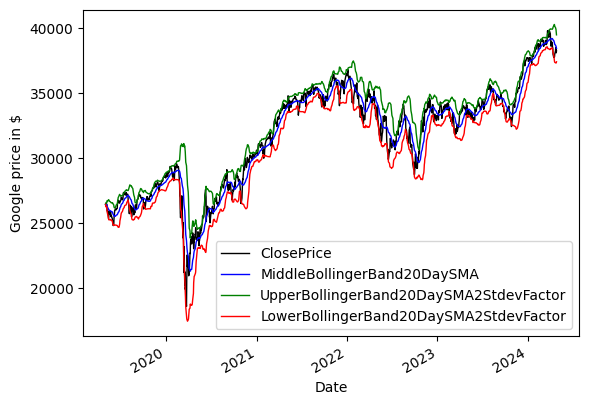

In [10]:
import statistics as stats
import math as math
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)
dji_data_result.index = pd.to_datetime(dji_data_result.index)
close = dji_data_result['Close']

time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands

history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
    history.append(close_price)

    if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma) # simple moving average or middle band
    variance = 0 # variance is the square of standard deviation

    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation
    upper_band.append(sma + stdev_factor * stdev)
    lower_band.append(sma - stdev_factor * stdev)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
mband = dji_data_result['MiddleBollingerBand20DaySMA']
uband = dji_data_result['UpperBollingerBand20DaySMA2StdevFactor']
lband = dji_data_result['LowerBollingerBand20DaySMA2StdevFactor']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=1., legend=True)
mband.plot(ax=ax1, color='b', lw=1., legend=True)
uband.plot(ax=ax1, color='g', lw=1., legend=True)
lband.plot(ax=ax1, color='r', lw=1., legend=True)
plt.show()

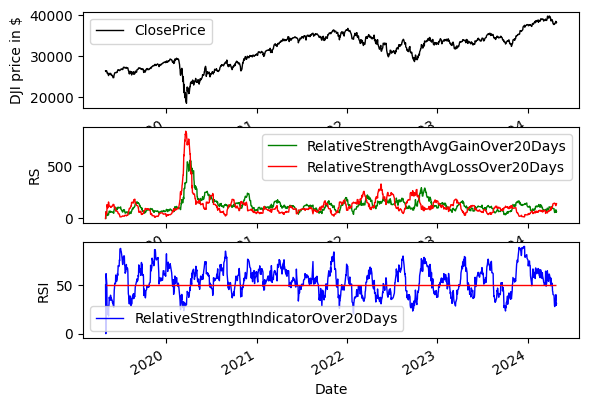

In [17]:
import statistics as stats
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)
dji_data_result.index = pd.to_datetime(dji_data_result.index)
close = dji_data_result['Close']

time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
    if last_price == 0:
        last_price = close_price

    gain_history.append(max(0, close_price - last_price))
    loss_history.append(max(0, last_price - close_price))
    last_price = close_price

    if len(gain_history) > time_period: # maximum observations is equal to lookback period
        del (gain_history[0])
        del (loss_history[0])
    
    avg_gain = stats.mean(gain_history) # average gain over lookback period
    avg_loss = stats.mean(loss_history) # average loss over lookback period
    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)

    rs = 1
    if avg_loss > 0: # to avoid division by 0, which is undefined
        rs = avg_gain / avg_loss
    
    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
rs_gain = dji_data_result['RelativeStrengthAvgGainOver20Days']
rs_loss = dji_data_result['RelativeStrengthAvgLossOver20Days']
rsi = dji_data_result['RelativeStrengthIndicatorOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='black', lw=1., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=1., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=1., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=1., legend=True)
plt.hlines(50, dji_data_result.index.values[0], dji_data_result.index.values[-1], linewidth=1, color='r')
plt.show()

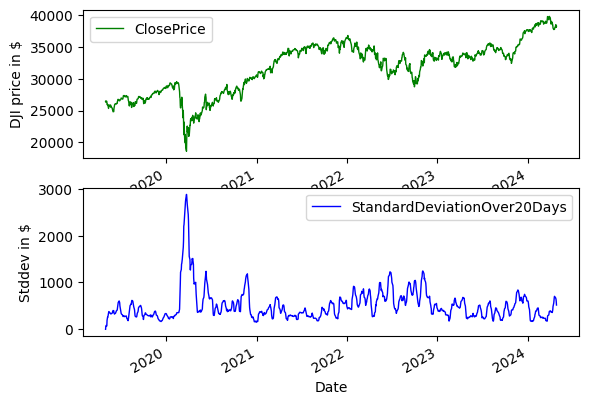

In [18]:
import statistics as stats
import math as math
import pandas as pd

dji_data_result = pd.read_csv('dji_data.csv', index_col=0)
dji_data_result.index = pd.to_datetime(dji_data_result.index)
close = dji_data_result['Close']

time_period = 20 # look back period

history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we track at most 'time_period' number of prices
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma)
    variance = 0 # variance is square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history))
    stddev_values.append(stdev)

dji_data_result = dji_data_result.assign(ClosePrice=pd.Series(close, index=dji_data_result.index))
dji_data_result = dji_data_result.assign(StandardDeviationOver20Days=pd.Series(stddev_values, index=dji_data_result.index))
close_price = dji_data_result['ClosePrice']
stddev = dji_data_result['StandardDeviationOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='DJI price in $')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
stddev.plot(ax=ax2, color='b', lw=1., legend=True)
plt.show()